<a href="https://colab.research.google.com/github/Dev-hottae/PINC/blob/master/Data_Analysis/Train_XGBoost_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# matplotlib 설정
import numpy as np
import pandas as pd
import xgboost as xgb
import gc

from tqdm import tqdm
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import rc
from xgboost import plot_importance
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, GridSearchCV

%matplotlib inline

# mac OS 에서 한글이 깨진다면 참고.
rc('font', family = 'AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
!pip install xgboost

In [3]:
data = pd.read_csv('/content/drive/My Drive/머신러닝/팀 프로젝트/06. AI를 이용한 금융 보고서/Data_Analysis/DataSet/Samsung.csv')
data

,date,price,volume,stocks_volume,total_cap
0,2004-06-01,10300,15502150,155609337,8.013880e+13
1,2004-06-02,10040,25799400,155609337,7.811590e+13
2,2004-06-03,9470,51001650,155609337,7.368100e+13
3,2004-06-04,9620,33963600,155609337,7.484810e+13
4,2004-06-07,9920,28310150,155609337,7.718220e+13
...,...,...,...,...,...
4065,2020-11-02,57400,20489076,5969782550,3.426660e+14
4066,2020-11-03,58800,14950919,5969782550,3.510230e+14
4067,2020-11-04,58500,21718561,5969782550,3.492320e+14
4068,2020-11-05,60300,20639475,5969782550,3.599780e+14


In [4]:
data['date'] = data['date'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))
data

,date,price,volume,stocks_volume,total_cap
0,2004-06-01,10300,15502150,155609337,8.013880e+13
1,2004-06-02,10040,25799400,155609337,7.811590e+13
2,2004-06-03,9470,51001650,155609337,7.368100e+13
3,2004-06-04,9620,33963600,155609337,7.484810e+13
4,2004-06-07,9920,28310150,155609337,7.718220e+13
...,...,...,...,...,...
4065,2020-11-02,57400,20489076,5969782550,3.426660e+14
4066,2020-11-03,58800,14950919,5969782550,3.510230e+14
4067,2020-11-04,58500,21718561,5969782550,3.492320e+14
4068,2020-11-05,60300,20639475,5969782550,3.599780e+14


In [5]:
def data_setting(df, window_size=7):
    stock_date = df['date'].tolist()
    stock_price = df['price'].tolist()
    stock_volume = df['volume'].tolist()
    stock_total_capital = df['total_cap'].tolist()
    window_size = window_size

    x_price, x_volume, x_total_capital, y_price = [], [], [], []
    for i in range(0, len(stock_price)-window_size*2+1):
        x_price.append(stock_price[i:i+window_size])
        x_volume.append(stock_volume[i:i+window_size])
        x_total_capital.append(stock_total_capital[i:i+window_size])

        y_price.append(stock_price[i+window_size:i+window_size*2])

    x_price = np.array(x_price).reshape(-1, window_size, 1)
    x_volume = np.array(x_volume).reshape(-1, window_size, 1)
    x_total_capital = np.array(x_total_capital).reshape(-1, window_size, 1)

    X = np.concatenate([x_price, x_volume, x_total_capital], axis=2)
    Y = np.array(y_price)

    return X, Y

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
from sklearn.metrics import r2_score
window = 15
xgb_pred = []
mape = []

# for i in tqdm(range(2)):
X, Y = data_setting(data, window)
# XGBoost는 3차원을 인식 못하므로 2차원으로 펴주는 과정 필요
X_train, y_train, X_test, y_test = X[:-window], Y[:-window], X[-window:], Y[-window:]
X_train = X_train.reshape(len(X_train), -1) 
X_test = X_test.reshape(len(X_test), -1)
# XGBoost 파라미터 설정
cv_parameters = {'estimator__n_estimators': [500, 800, 1000, 1600, 2400],
                 'estimator__max_depth': [3,6,8,10]}
xgb_params = {'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
# XGBoostRegressor 설정
search = GridSearchCV(xgb.XGBRegressor(**xgb_params), cv_parameters, cv = 3, n_jobs = -1)
multi_search = MultiOutputRegressor(search)
print("학습을 진행합니다. 현재 에폭 : {}".format(1))
multi_search.fit(X_train, y_train)
#multi_search.best_params_
print("="*30)
# 예측 결과
y_pred = multi_search.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE Score : {}".format(mape))

In [ ]:
stock_date = data['date'].tolist()
stock_price = data['price'].tolist()

predict_date = stock_date[-window:]
for i in range(1, window+1):
    predict_date.append(stock_date[-1] + timedelta(days=i))

In [59]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE Score : {}".format(mape))

MAPE Score : 4.030616463459561


In [57]:
new_pred = y_pred[0].tolist()
second_pred = y_pred[-1].tolist()
new_pred.extend(second_pred)
len(new_pred)

30

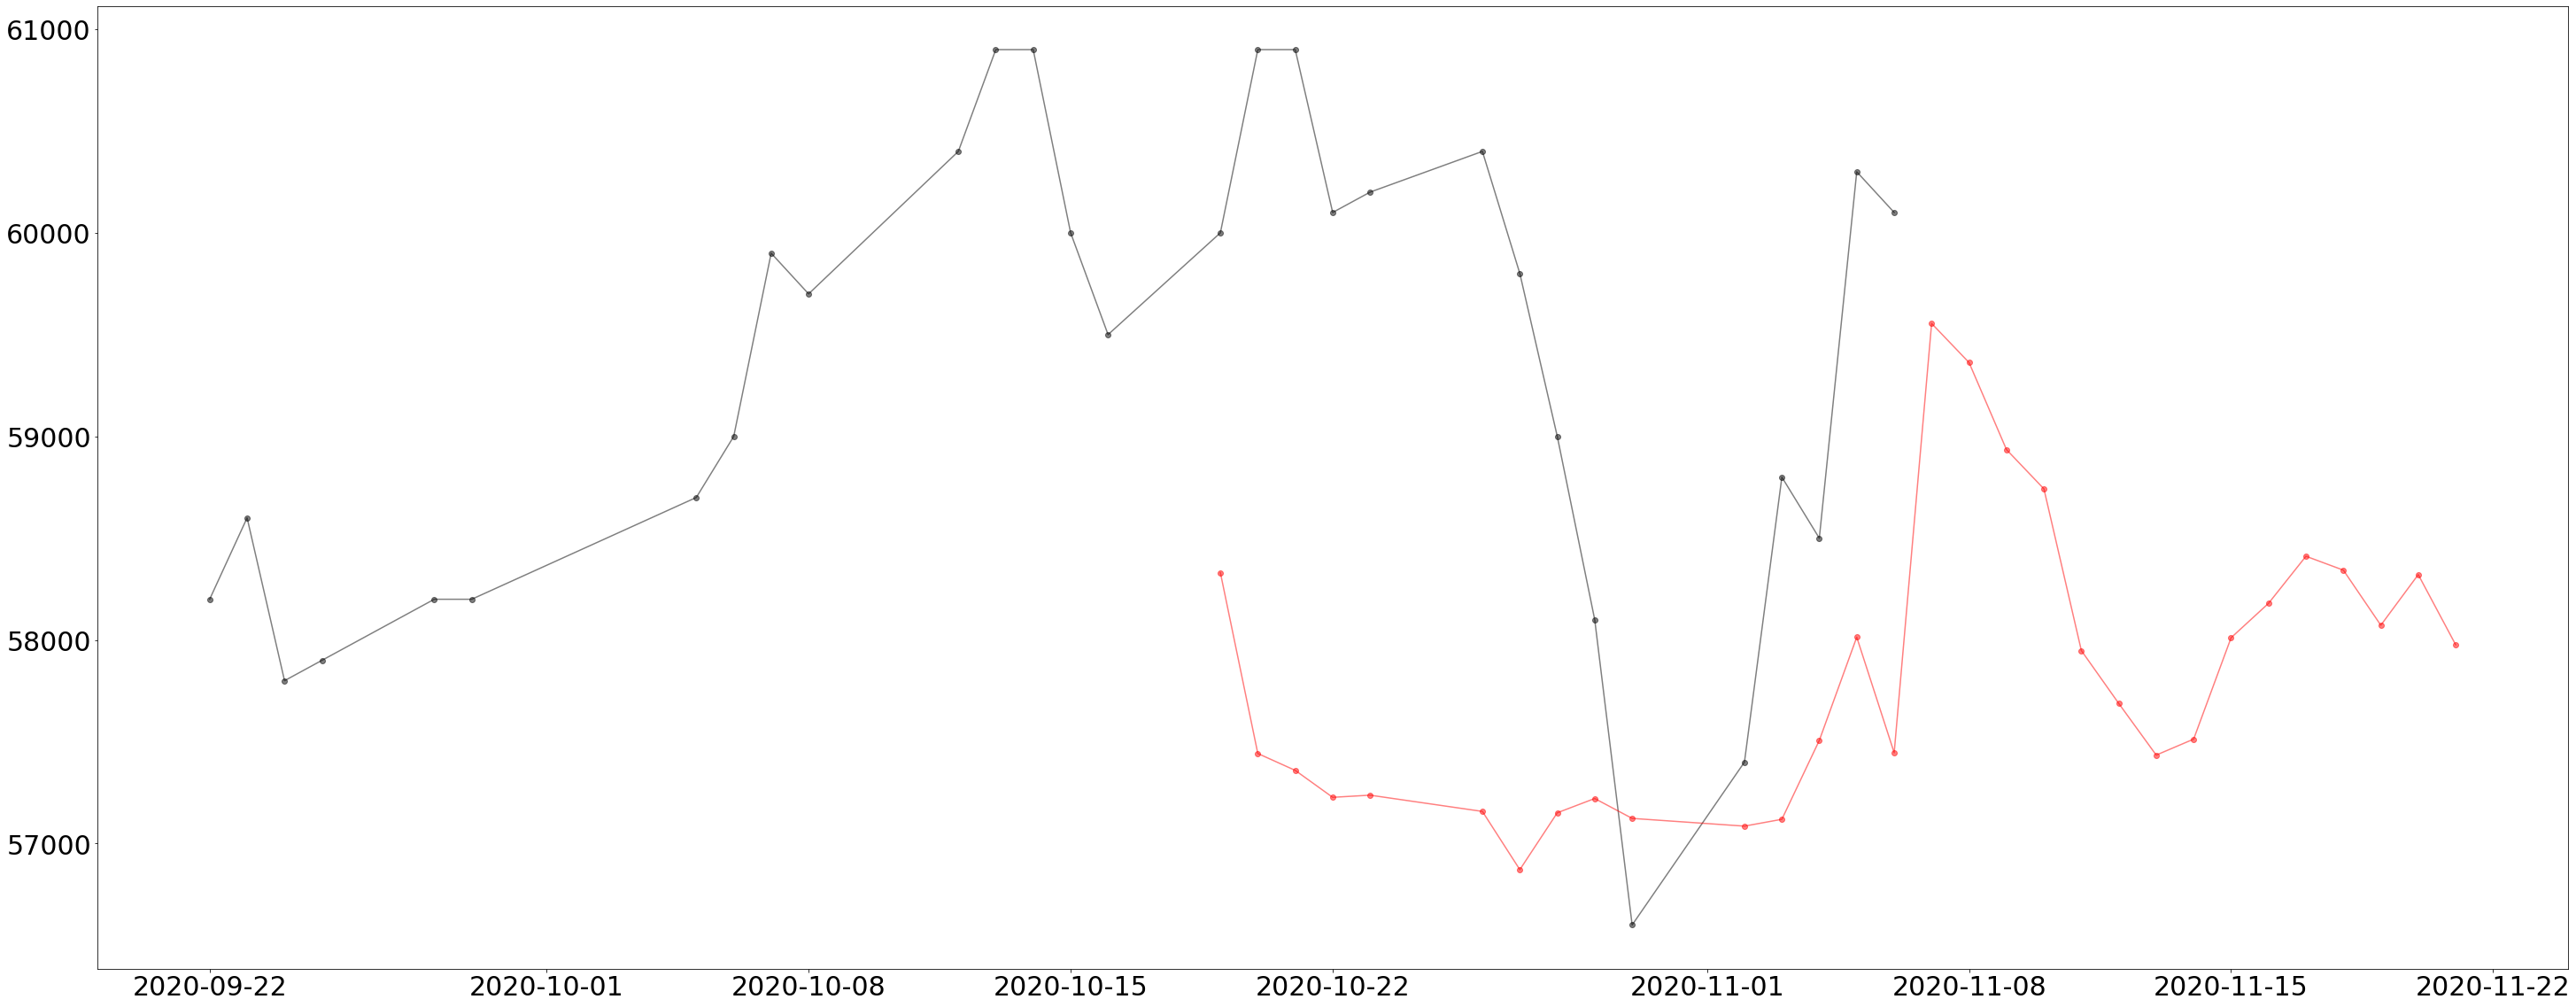

In [58]:
plt.figure(figsize=(50, 20))
plt.plot(stock_date[-window*2:], stock_price[-window*2:], marker='o', color = 'black', label='Real Price', alpha = 0.5)
plt.plot(predict_date, new_pred, marker='o', color = 'red', label='Predict Price', alpha = 0.5)
plt.tick_params(labelsize=30)